# Ансамбли моделей машинного обучения.

### Импорт библиотек

In [19]:
import numpy as np
import pandas as pd
from io import StringIO 
from IPython.display import Image
from heamy.dataset import Dataset
from heamy.estimator import Regressor, Classifier
from heamy.pipeline import ModelsPipeline
from gmdhpy import gmdh
import pydotplus
import seaborn as sns
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.svm import SVR
import operator
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.datasets import *
sns.set(style="ticks")

### Загрузка данных

В качестве набора данных мы будем использовать набор данных о заболеваемости диабетом из пакета sklearn.
Загрузим файлы датасета из библиатеке `sklearn.datasets`, и преобразуем в `DataFrame` библиотеки *Pandas*.


In [2]:
ds = load_diabetes()
df = pd.DataFrame(data= np.c_[ds['data'], ds['target']],
                 columns= list(ds['feature_names']) + ['target'])
df.count()

age       442
sex       442
bmi       442
bp        442
s1        442
s2        442
s3        442
s4        442
s5        442
s6        442
target    442
dtype: int64

In [3]:
df.corr()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
age,1.000000,0.173737,0.185085,0.335427,0.260061,0.219243,-0.075181,0.203841,0.270777,0.301731,0.187889
sex,0.173737,1.000000,0.088161,0.241013,0.035277,0.142637,-0.379090,0.332115,0.149918,0.208133,0.043062
bmi,0.185085,0.088161,1.000000,0.395415,0.249777,0.261170,-0.366811,0.413807,0.446159,0.388680,0.586450
bp,0.335427,0.241013,0.395415,1.000000,0.242470,0.185558,-0.178761,0.257653,0.393478,0.390429,0.441484
s1,0.260061,0.035277,0.249777,0.242470,1.000000,0.896663,0.051519,0.542207,0.515501,0.325717,0.212022
s2,0.219243,0.142637,0.261170,0.185558,0.896663,1.000000,-0.196455,0.659817,0.318353,0.290600,0.174054
s3,-0.075181,-0.379090,-0.366811,-0.178761,0.051519,-0.196455,1.000000,-0.738493,-0.398577,-0.273697,-0.394789
s4,0.203841,0.332115,0.413807,0.257653,0.542207,0.659817,-0.738493,1.000000,0.617857,0.417212,0.430453
s5,0.270777,0.149918,0.446159,0.393478,0.515501,0.318353,-0.398577,0.617857,1.000000,0.464670,0.565883
s6,0.301731,0.208133,0.388680,0.390429,0.325717,0.290600,-0.273697,0.417212,0.464670,1.000000,0.382483


In [4]:
df.isnull().sum()

age       0
sex       0
bmi       0
bp        0
s1        0
s2        0
s3        0
s4        0
s5        0
s6        0
target    0
dtype: int64

### Подготовка данных

Поделим данные на тестовую и тренеровочную выборку в пропорции 1 к 4

In [5]:
df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(
    df.drop(columns='target'), df['target'], test_size=0.2, random_state=12)

### Случаный лес

In [6]:
tree = RandomForestRegressor(n_estimators=10, random_state=12)
tree.fit(df_X_train, df_y_train)
tree_y = tree.predict(df_X_test)

In [7]:
tree_y

array([184.2, 136.3, 143.7, 114.2, 194.2, 160. ,  71.1, 245.4, 136.7,
       243.8, 260.5, 201.4, 161. , 154.4, 105.5, 224.8, 173.3,  66.5,
       199. , 152.2, 156.2, 122. , 261.1, 142.5, 157.8, 108.8, 156. ,
       126.6,  68. , 144.4, 174.4, 162.7, 181.5,  93.4, 117.1, 191.8,
       112.1, 212.8, 222.9, 191. , 236.7, 200.5, 123.4,  77. , 182.3,
        76.6, 223.3,  80.9, 263.9, 290.8,  95.8, 172.5, 214.2, 181.3,
       150.5, 132.3, 142.8, 205.9, 225. , 238.1, 266.8, 101. , 140.8,
       113.8,  76.5,  71.1, 139.7, 216.7, 100.7, 155.6,  85.8,  72.2,
        79.9,  82. , 123.8, 190.6, 126.7, 129.6, 152.8, 181.6, 117.5,
       179. ,  91.2,  84.9, 100.2, 174.3, 244.2, 148.2,  56.2])

### Бустинг

In [8]:
reg = xgb.XGBRegressor(
    n_estimators=10,
    eval_metric=mean_squared_error,
)
reg.fit(df_X_train, df_y_train, eval_set=[(df_X_train, df_y_train)])
reg_y = reg.predict(df_X_test)

[0]	validation_0-rmse:126.78217
[1]	validation_0-rmse:95.65629
[2]	validation_0-rmse:73.21293
[3]	validation_0-rmse:57.39291
[4]	validation_0-rmse:46.06264
[5]	validation_0-rmse:38.16575
[6]	validation_0-rmse:32.10063
[7]	validation_0-rmse:27.78214
[8]	validation_0-rmse:23.98275
[9]	validation_0-rmse:21.76612


D:\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [9]:
reg_y

array([149.30428 , 105.880424, 145.81374 , 102.04156 , 174.46553 ,
       114.801186, 110.59888 , 243.877   , 154.5212  , 237.16719 ,
       222.18236 , 217.16653 , 150.85403 , 134.93927 ,  95.98342 ,
       237.88918 , 180.51299 ,  83.54547 , 207.24379 , 109.5174  ,
       142.41653 , 119.48074 , 239.61699 , 103.94377 , 155.80708 ,
       130.35544 , 102.680244,  89.2868  ,  76.83893 , 145.3199  ,
       104.73179 , 145.29933 , 134.9832  , 120.21382 ,  85.30003 ,
       168.91045 ,  76.302284, 209.41447 , 228.50658 , 179.25017 ,
       202.60506 , 186.886   ,  85.2626  , 101.48372 , 173.86761 ,
        73.36852 , 214.41394 ,  84.811356, 232.04376 , 272.86478 ,
       101.107605, 146.30386 , 185.52725 , 171.97969 , 142.88792 ,
       112.13408 , 123.32981 , 248.35106 , 223.41351 , 244.65875 ,
       247.1172  ,  69.80298 , 153.20953 ,  87.67907 ,  92.2524  ,
        83.07777 ,  85.56129 , 217.9154  ,  94.80268 , 129.47073 ,
        83.429146,  83.567856,  82.01156 ,  52.425613,  99.195

### Стекинг

In [10]:
dataset = Dataset(df_X_train, df_y_train, df_X_test)

model_rf = Regressor(dataset=dataset, estimator=RandomForestRegressor, parameters={'n_estimators': 10},name='rf')
model_lr = Regressor(dataset=dataset, estimator=LinearRegression, parameters={'normalize': True},name='lr')

pipeline = ModelsPipeline(model_rf, model_lr)
stack_ds = pipeline.stack(k=15, seed=111)

stacker = Regressor(dataset=stack_ds, estimator=DecisionTreeRegressor)
stacker_y = stacker.predict()
results = stacker.validate(k=15, scorer=mean_squared_error)

Metric: mean_squared_error
Folds accuracy: [7022.25, 12363.958333333334, 5662.666666666667, 6137.416666666667, 8583.041666666666, 7334.791666666667, 5365.958333333333, 7370.333333333333, 6070.95652173913, 4447.173913043478, 4680.826086956522, 4341.521739130435, 8708.91304347826, 4379.521739130435, 4062.6521739130435]
Mean accuracy: 6435.465458937198
Standard Deviation: 2163.197180008688
Variance: 4679422.03959754


In [11]:
stacker_y

array([237., 170., 302., 137., 189., 124.,  79., 129., 244., 212., 277.,
       288., 263., 103.,  78., 275., 214.,  59.,  85., 144., 201.,  55.,
       243., 144.,  60.,  50., 262., 200., 128.,  71.,  91., 109., 138.,
        68.,  37., 222., 137., 233., 258., 172., 257., 192., 150., 114.,
       118., 129., 197.,  64., 258., 245.,  60.,  68., 189., 235., 185.,
       172., 198., 233., 275., 164., 242., 131., 110.,  87.,  45.,  63.,
       136., 232., 160., 272., 137.,  64.,  90.,  65.,  78., 131., 277.,
       113., 164., 265.,  71., 110., 135.,  91., 200., 128., 173.,  78.,
       104.])

### Многослойного персептрона

Для реализации данной модели будем использовать функционал библиоткеи TenserFlow

In [12]:
# Нормализуем обучающую выборку с помощью отдельного слоя нормализации
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(df_X_train))

In [13]:
print(normalizer.mean.numpy())

[[-0.00158359 -0.00089624  0.00031588 -0.00096308 -0.00051653 -0.00046802
  -0.00057182  0.00042046  0.0001608   0.00014264]]


In [14]:
df_X_train.describe()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
count,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000
mean,-0.001584,-0.000896,0.000316,-0.000963,-0.000517,-0.000468,-0.000572,0.000420,0.000161,0.000143
std,0.049006,0.047567,0.049150,0.048559,0.049247,0.048940,0.048204,0.048292,0.047684,0.046903
min,-0.107226,-0.044642,-0.090275,-0.112400,-0.126781,-0.112795,-0.102307,-0.076395,-0.126097,-0.129483
25%,-0.041840,-0.044642,-0.036385,-0.036656,-0.035968,-0.032002,-0.036038,-0.039493,-0.033249,-0.030072
50%,0.005383,-0.044642,-0.008362,-0.005671,-0.004321,-0.005072,-0.006584,-0.002592,-0.003304,-0.001078
75%,0.038076,0.050680,0.033673,0.034496,0.027326,0.031254,0.026550,0.034309,0.033047,0.027917
max,0.110727,0.050680,0.170555,0.132044,0.153914,0.198788,0.181179,0.185234,0.133599,0.135612


In [15]:
#Создадим нейроную сеть с одним скрытым слоем
nn_model = keras.Sequential([
      normalizer,
      layers.Dense(20, activation='relu'),
      layers.Dense(1)
  ])

nn_model.compile(loss='mean_squared_error',
            optimizer=tf.keras.optimizers.Adam(0.001))
history = nn_model.fit(
    df_X_train,
    df_y_train,
    validation_split=0.2,
    verbose=0,
    epochs=400
)
nn_y = nn_model.predict(df_X_test)
nn_y

3/3 [==============================] - 0s 1ms/step


array([[212.92929 ],
       [ 19.594112],
       [106.97292 ],
       [ 70.99605 ],
       [189.48883 ],
       [ 86.36806 ],
       [111.75647 ],
       [116.60968 ],
       [122.602585],
       [186.56653 ],
       [243.88792 ],
       [152.87848 ],
       [127.72024 ],
       [136.28882 ],
       [ 60.78453 ],
       [230.90665 ],
       [129.89294 ],
       [106.85017 ],
       [167.22697 ],
       [150.80173 ],
       [ 68.531204],
       [142.75902 ],
       [283.63235 ],
       [128.60912 ],
       [152.00255 ],
       [118.70987 ],
       [114.60079 ],
       [ 63.414852],
       [ 66.22781 ],
       [ 60.62016 ],
       [163.18936 ],
       [125.61765 ],
       [152.70609 ],
       [ 66.165245],
       [ 51.140064],
       [192.25508 ],
       [ 86.394844],
       [181.1155  ],
       [172.6566  ],
       [110.59793 ],
       [281.3926  ],
       [225.30415 ],
       [ 83.13081 ],
       [ 92.2989  ],
       [199.2587  ],
       [ 74.624916],
       [160.40106 ],
       [ 58.4

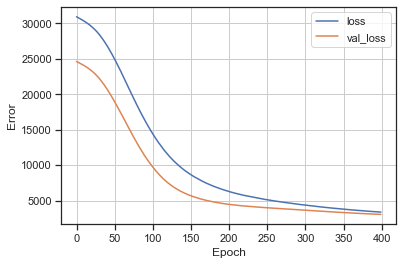

In [16]:
# посмотрим историю обучения

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.grid(True)

### Модель МГУА 

In [28]:
gmdh_model = gmdh.Regressor(ref_functions=('linear_cov', 'quadratic', 'cubic', 'linear'))
gmdh_model.fit(df_X_train.values, df_y_train.values)
gmdh_y = gmdh_model.predict(df_X_test.values)
gmdh_y

train layer0 in 0.18 sec
train layer1 in 0.53 sec
train layer2 in 0.52 sec
train layer3 in 0.52 sec
train layer4 in 0.51 sec
train layer5 in 0.53 sec


array([209.10020708, 122.5295096 , 159.51721852,  99.38626424,
       193.47445709, 138.60592576, 122.73902489, 165.22235386,
       178.97968777, 189.02133524, 258.40734395, 179.30405188,
       135.75473228, 141.39286193,  68.37846824, 218.25632299,
       152.71693688,  73.28522292, 171.01202591, 194.23892706,
       127.43402267,  81.2616121 , 244.41066279, 142.97809548,
       148.28352379, 105.93573428, 164.23881249, 116.73649724,
        91.84712255, 127.59577046, 153.39128262, 178.53827268,
       176.22114935, 126.20823383, 103.85699124, 169.48493727,
       101.92350582, 194.07724585, 168.23861498, 145.92825908,
       264.6936559 , 230.78248817, 142.74540707,  84.90167377,
       187.76470783, 124.70535705, 179.84582544, 103.29003094,
       199.52872972, 271.75801822,  97.38062031, 124.40470526,
       211.20313612, 155.36240341, 197.9754771 , 156.52174031,
       173.60673959, 187.08229415, 189.81847303, 194.86499065,
       249.71941818, 140.51922649, 128.79353257,  94.69

### Оценка моделей

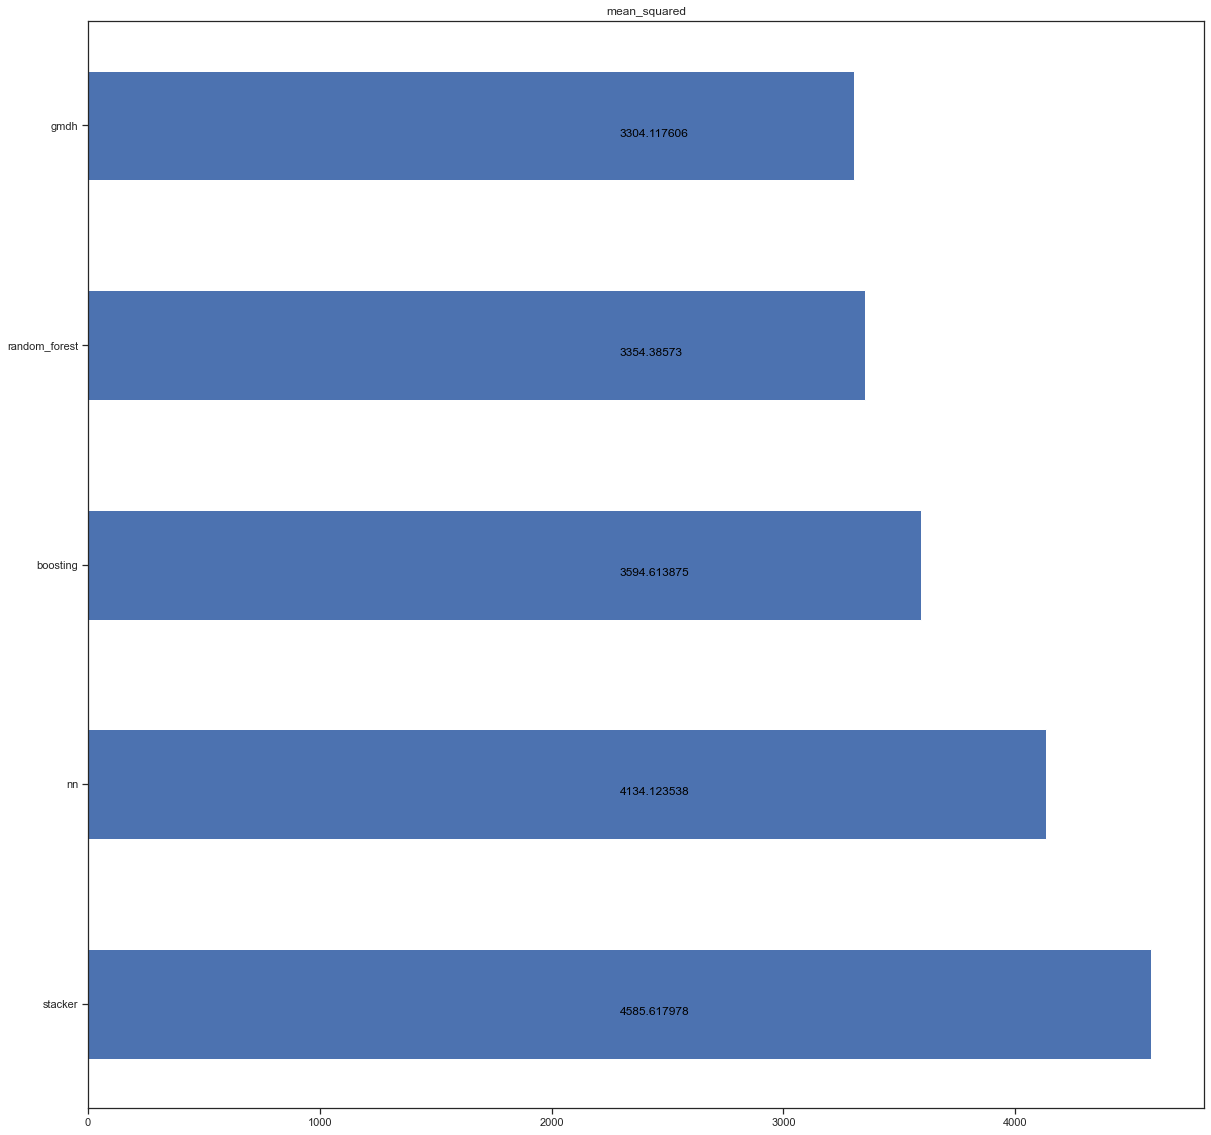

In [37]:
results_metrics = [mean_squared_error(df_y_test, tree_y), mean_squared_error(df_y_test, reg_y), mean_squared_error(df_y_test, stacker_y), mean_squared_error(df_y_test, nn_y), mean_squared_error(df_y_test, gmdh_y)]
model_list = ['random_forest', 'boosting', 'stacker', 'nn', 'gmdh']

sorted_el = list(sorted(list(zip(model_list, results_metrics)), key=lambda x: -x[1]))
results_metrics = list(map(lambda x: x[1], sorted_el))
model_list = list(map(lambda x: x[0], sorted_el))

fig, ax = plt.subplots(figsize=(20,20))
pos = np.arange(len(model_list))
rects = ax.barh(pos, results_metrics,
             align='center',
             height=0.5, 
             tick_label=model_list)
ax.set_title('mean_squared')
for a, b in zip(pos, results_metrics):
    plt.text(max(results_metrics)/2, a-0.05, str(round(b,6)), color='black')
plt.show() 